Kaggle Dataset of BRaTs2020

https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/data


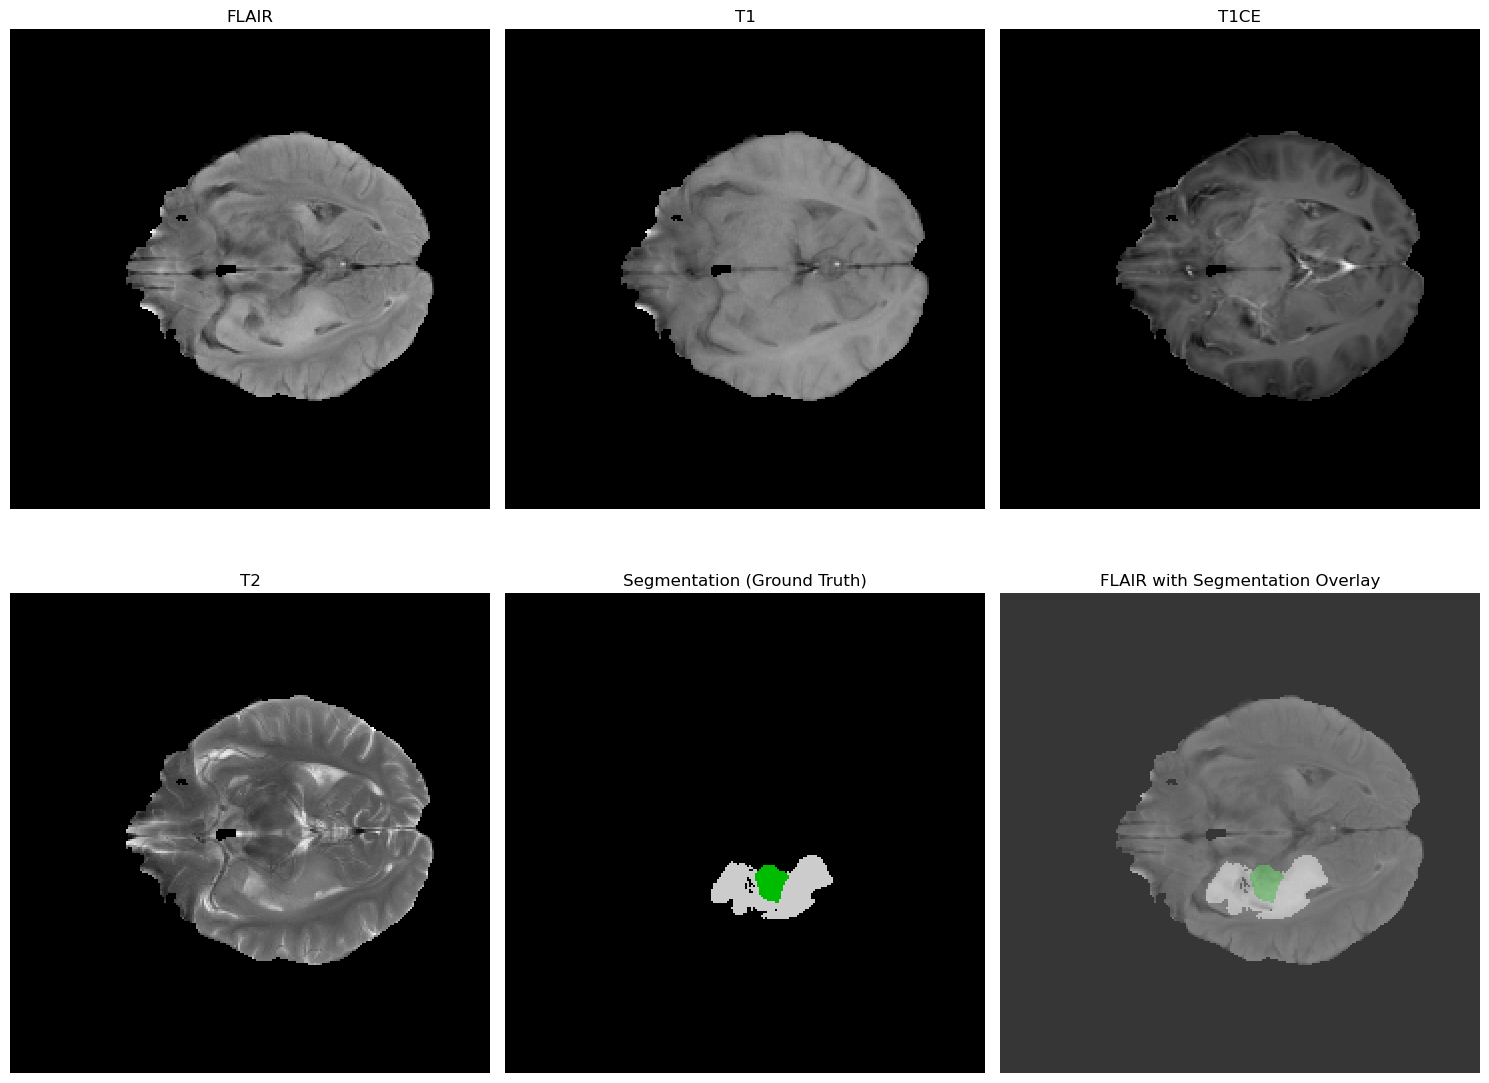

In [47]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the BraTS2020 dataset directory
dataset_path = "/Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData" # Change to your downloaded file unzipped (too large for Git)

# Function to load a NIfTI file
def load_nifti(file_path):
    """Load a NIfTI file and return the data as a NumPy array."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

# List all patient folders in the dataset
cases = [case for case in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, case))]

# Example: Load and visualize data for one case
example_case = cases[9]  # Select the first case, e.g., BraTS20_Training_369
case_path = os.path.join(dataset_path, example_case)

# Define the actual file paths based on patient folder structure
modalities = ["flair", "t1", "t1ce", "t2"]
modality_files = {modality: os.path.join(case_path, f"{example_case}_{modality}.nii") for modality in modalities}
segmentation_file = os.path.join(case_path, f"{example_case}_seg.nii")

# Check if all files exist
for file_path in list(modality_files.values()) + [segmentation_file]:
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

# Load the NIfTI files for modalities and segmentation
loaded_modalities = {modality: load_nifti(file) for modality, file in modality_files.items()}
segmentation = load_nifti(segmentation_file)

# Visualize an example slice
slice_idx = 60  # You can modify this index to explore different slices

plt.figure(figsize=(15, 12))

# Plot the modalities
for i, (modality, data) in enumerate(loaded_modalities.items()):
    plt.subplot(2, 3, i + 1)
    plt.imshow(data[:, :, slice_idx], cmap="gray")
    plt.title(modality.upper())
    plt.axis("off")

# Plot the segmentation mask
plt.subplot(2, 3, 5)
plt.imshow(segmentation[:, :, slice_idx], cmap="nipy_spectral")
plt.title("Segmentation (Ground Truth)")
plt.axis("off")

# Overlay segmentation mask on one modality (e.g., FLAIR)
plt.subplot(2, 3, 6)
plt.imshow(loaded_modalities["flair"][:, :, slice_idx], cmap="gray", alpha=0.7)
plt.imshow(segmentation[:, :, slice_idx], cmap="nipy_spectral", alpha=0.3)
plt.title("FLAIR with Segmentation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


Model Creation

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Attention block
def attention_block(x, g, inter_channels):
    """Attention mechanism for encoder-decoder architecture."""
    theta_x = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='sigmoid')(f)
    return layers.multiply([x, psi_f])

# Encoder-decoder with depthwise separable convolutions
def attention_unet(input_shape=(240, 240, 4), num_classes=5):
    """Custom U-Net with depthwise separable convolutions and attention."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, attention_block(c3, u5, 128)])
    c5 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, attention_block(c2, u6, 64)])
    c6 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, attention_block(c1, u7, 32)])
    c7 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    return Model(inputs, outputs)

# Instantiate the model
model = attention_unet()


In [23]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    """Calculate Dice loss."""
    # Debugging: Print shapes
    tf.debugging.assert_equal(tf.shape(y_true), tf.shape(y_pred), message="y_true and y_pred shapes do not match in dice_loss")
    
    # Ensure y_true and y_pred are both float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """Calculate Focal loss."""
    # Debugging: Print shapes
    tf.debugging.assert_equal(tf.shape(y_true), tf.shape(y_pred), message="y_true and y_pred shapes do not match in focal_loss")
    
    # Ensure y_true and y_pred are both float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    loss = -y_true * alpha * (1 - y_pred)**gamma * tf.math.log(y_pred)
    return tf.keras.backend.mean(tf.keras.backend.sum(loss, axis=-1))


def hybrid_loss(y_true, y_pred):
    """Combine Dice loss and Focal loss."""
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)


In [24]:
# Normalize and resize data
def preprocess(image, mask):
    """Normalize images and one-hot encode masks."""
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.int32)

    # One-hot encode masks
    mask = tf.one_hot(mask[..., 0], depth=5)  # 5 classes (0, 1, 2, 4, and background)
    return image, mask


# Data augmentation
@tf.function
def augment(images, masks):
    """Apply random augmentation."""
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    return images, masks


In [25]:
import os
import nibabel as nib
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ============================================
# Dataset Preprocessing Functions
# ============================================
def load_nifti(file_path):
    """Load a NIfTI file and return the data as a NumPy array."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

def preprocess_and_yield(case_path, target_shape=(240, 240)):
    """
    Load modalities and segmentation for a single case, preprocess, 
    and yield individual 2D slices as memory-efficient batches.
    """
    modalities = ["flair", "t1", "t1ce", "t2"]
    modality_files = {modality: os.path.join(case_path, f"{case_path.split('/')[-1]}_{modality}.nii") for modality in modalities}
    segmentation_file = os.path.join(case_path, f"{case_path.split('/')[-1]}_seg.nii")

    # Load modalities and segmentation
    images = np.stack([load_nifti(modality_files[modality]) for modality in modalities], axis=-1)
    mask = load_nifti(segmentation_file)
    
    # Normalize images
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    
    # Yield slices one by one
    for slice_idx in range(images.shape[2]):  # Iterate over slices
        slice_img = tf.image.resize(images[:, :, slice_idx, :], target_shape).numpy()
        slice_mask = tf.image.resize(mask[:, :, slice_idx][..., np.newaxis], target_shape, method='nearest').numpy()
        yield slice_img, slice_mask

def slice_generator(case_paths, target_shape=(240, 240)):
    """Generator to yield slices from all patient cases."""
    for case_path in case_paths:
        print(f"Processing {case_path}...")
        for img, mask in preprocess_and_yield(case_path, target_shape):
            # Ensure slices have the correct shape
            yield img, mask


# ============================================
# Split Dataset into Train, Validation, Test
# ============================================
def prepare_split_cases(dataset_path, test_size=0.2, val_size=0.1):
    """
    Split the dataset into train, validation, and test cases for memory-efficient processing.
    """
    # Gather all cases
    case_folders = [os.path.join(dataset_path, case) for case in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, case))]

    # Split case folders into train, val, and test
    train_cases, test_cases = train_test_split(case_folders, test_size=test_size, random_state=42)
    train_cases, val_cases = train_test_split(train_cases, test_size=val_size, random_state=42)

    return train_cases, val_cases, test_cases

# ============================================
# Create TensorFlow Datasets
# ============================================
def tf_dataset(case_paths, batch_size=16, target_shape=(240, 240), augment_flag=False):
    """Create a TensorFlow dataset from a generator."""
    def generator():
        return slice_generator(case_paths, target_shape)

    dataset = tf.data.Dataset.from_generator(generator, 
                                             output_signature=(
                                                 tf.TensorSpec(shape=(240, 240, 4), dtype=tf.float32),
                                                 tf.TensorSpec(shape=(240, 240, 1), dtype=tf.int32)
                                             ))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if augment_flag:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    # Ensure batching is applied here without introducing extra dimensions
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# ============================================
# Main Script
# ============================================
# Define dataset path and parameters
dataset_path = "/Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # Update this path
target_shape = (240, 240)  # Resize images to this shape
batch_size = 16

# Prepare case splits
train_cases, val_cases, test_cases = prepare_split_cases(dataset_path)

# Create TensorFlow datasets
train_dataset = tf_dataset(train_cases, batch_size=batch_size, target_shape=target_shape, augment_flag=True)
val_dataset = tf_dataset(val_cases, batch_size=batch_size, target_shape=target_shape, augment_flag=False)
test_dataset = tf_dataset(test_cases, batch_size=batch_size, target_shape=target_shape, augment_flag=False)

print("Datasets created successfully!")


Datasets created successfully!


In [27]:
# ============================================
# Compile and Train the Model
# ============================================
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=hybrid_loss,
              metrics=['accuracy', dice_loss])

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=2,
                    steps_per_epoch=100,  # Adjust based on dataset size
                    validation_steps=20)  # Adjust based on dataset size

# ============================================
# Evaluate the Model
# ============================================
# Prepare test dataset
test_dataset = tf_dataset(test_cases, batch_size=16, augment_flag=False)

# Evaluate on test dataset
test_loss, test_accuracy, test_dice_loss = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Loss: {test_dice_loss}")

Epoch 1/2
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_121...
100/100 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.9921 - dice_loss: 0.7529Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_196...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_132...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_306...
100/100 [==============================] - 158s 2s/step - loss: 0.9519 - accuracy: 0.9921 - dice_loss: 0.7529 - val_loss: 0.8767 - val_accuracy: 0.9814 - val_dice_loss: 0.7153
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.9905 - dice_loss: 0.4332Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/

Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_196...
1/1 [==============================] - 0s 37ms/step


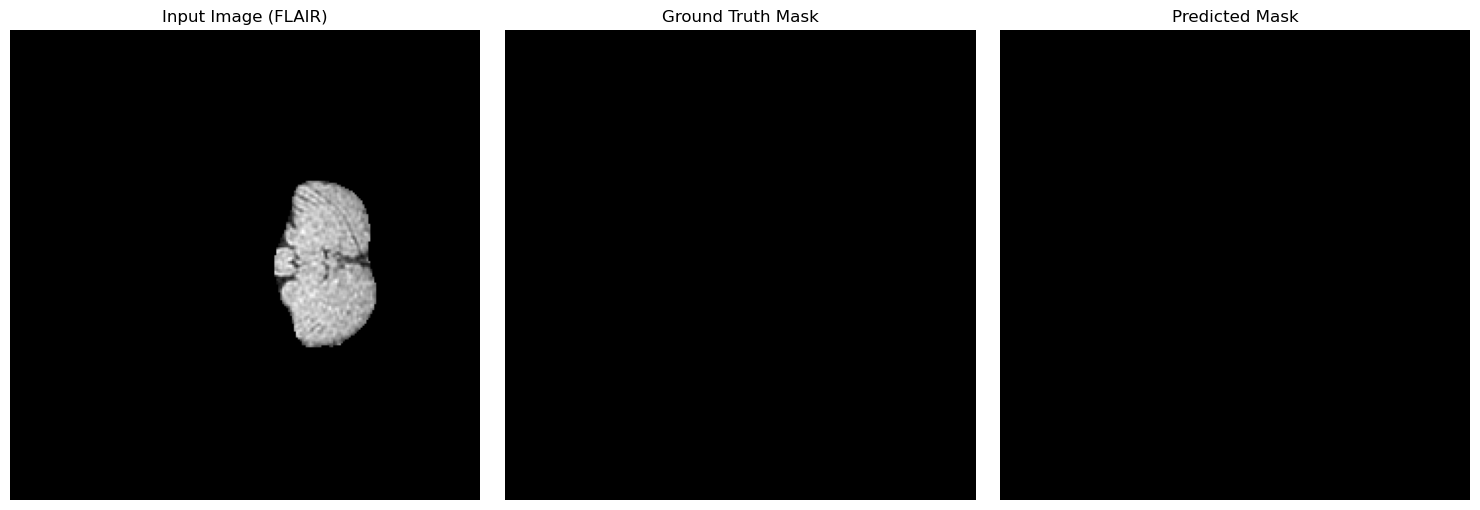

In [32]:
# Fetch a sample from the validation dataset
for images, masks in val_dataset.take(1):  # Take a batch from the validation dataset
    sample_images = images.numpy()  # Convert TensorFlow tensor to NumPy array
    sample_masks = masks.numpy()  # Convert TensorFlow tensor to NumPy array
    break

# Predict on the first image in the batch
sample_idx = 10
predictions = model.predict(sample_images[sample_idx:sample_idx+1])
predicted_mask = tf.argmax(predictions[0], axis=-1).numpy()  # Convert predicted mask to NumPy

# Visualize the results
plt.figure(figsize=(15, 5))

# Input image (first modality, e.g., FLAIR)
plt.subplot(1, 3, 1)
plt.imshow(sample_images[sample_idx][:, :, 0], cmap='gray')  # Display the first modality
plt.title("Input Image (FLAIR)")
plt.axis("off")

# Ground truth mask
plt.subplot(1, 3, 2)
ground_truth_mask = tf.argmax(sample_masks[sample_idx], axis=-1).numpy()  # Convert one-hot to class indices
plt.imshow(ground_truth_mask, cmap='nipy_spectral')
plt.title("Ground Truth Mask")
plt.axis("off")

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='nipy_spectral')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
